# Connect 4 — CNN & Transformer Training (70–80% Target)

**Project deliverables**: Train both a **CNN** and a **Transformer** for 7-class classification.

- Path auto-detect: Colab (Drive) or local `Connect4_Combined`
- On-the-fly horizontal flip augmentation
- Upgraded architectures + warmup/cosine LR + Phase 2 fine-tune if val_acc < 72%
- Saves: `connect4_cnn_best.keras`, `connect4_transformer_best.keras`

## 1. Setup, Paths & Config

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Mount Drive (Colab only)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass

# Path auto-detect: Colab vs local
if os.path.exists('/content/drive/MyDrive/Connect4_Combined'):
    BASE = '/content/drive/MyDrive/Connect4_Combined'
else:
    BASE = os.path.join(os.getcwd(), 'Connect4_Combined')

COMBINED_DATASET = f'{BASE}/datasets/connect4_combined_unique.npz'
MODEL_DIR = f'{BASE}/models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Configurable parameters
TARGET_VAL_ACC = 0.72
EPOCHS_PHASE1 = 60
EPOCHS_FINETUNE = 10
BATCH_SIZE = 256
INIT_LR = 1e-3
FINETUNE_LR = 1e-5
WARMUP_EPOCHS = 3
EARLY_STOP_PATIENCE = 10
AUG_FLIP_PROB = 0.5
SEED = 42
NUM_CLASSES = 7

np.random.seed(SEED)
tf.random.set_seed(SEED)

print('Loading dataset...')
npz = np.load(COMBINED_DATASET)
X_train = npz['X_train']
y_train = npz['y_train']
X_val = npz['X_val']
y_val = npz['y_val']
X_test = npz['X_test']
y_test = npz['y_test']
print(f'Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}')
print(f'Model dir: {MODEL_DIR}')

Mounted at /content/drive
Loading dataset...
Train: 636,100 | Val: 79,512 | Test: 79,512
Model dir: /content/drive/MyDrive/Connect4_Combined/models


## 2. Data Pipeline (augmentation + one-hot)

In [2]:
def augment_and_one_hot(x, y):
    """On-the-fly horizontal flip (AUG_FLIP_PROB) + one-hot labels."""
    if tf.random.uniform(()) < AUG_FLIP_PROB:
        x = tf.image.flip_left_right(x)
        y = 6 - y
    return x, tf.one_hot(tf.cast(y, tf.int32), NUM_CLASSES)

def to_one_hot(x, y):
    return x, tf.one_hot(tf.cast(y, tf.int32), NUM_CLASSES)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(20000, seed=SEED).map(augment_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(to_one_hot, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print('Data pipeline ready (augmentation on train only)')

Data pipeline ready (augmentation on train only)


## 3. Mixed Precision & LR Schedule

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print('Mixed precision enabled')

def warmup_cosine_lr(epoch, lr):
    if epoch < WARMUP_EPOCHS:
        return INIT_LR * (epoch + 1) / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / max(1, EPOCHS_PHASE1 - WARMUP_EPOCHS)
    return FINETUNE_LR + 0.5 * (INIT_LR - FINETUNE_LR) * (1 + np.cos(np.pi * progress))

Mixed precision enabled


## 4. Build CNN (10 res blocks, 256 filters, BatchNorm)

In [4]:
L2_REG = 1e-4

def res_block(x, filters=256):
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=keras.regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=keras.regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

inputs = keras.Input(shape=(6, 7, 2))
x = layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.l2(L2_REG))(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
for _ in range(10):
    x = res_block(x, 256)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(L2_REG))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(L2_REG))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

cnn_model = keras.Model(inputs, outputs)
cnn_model.compile(
    optimizer=keras.optimizers.Adam(INIT_LR),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')
    ]
)
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 7, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 6, 7, 128) │      2,432 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6, 7, 128) │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 6, 7, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 7, 128) │    147,584 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 7, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 6, 7, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 7, 128) │    147,584 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 7, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 7, 128) │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 6, 7, 128) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 7, 128) │    147,584 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 7, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 6, 7, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 7, 128) │    147,584 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 7, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 6, 7, 128) │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 6, 7, 128) │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 6, 7, 128) │    147,584 │ re_lu_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 7, 128) │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,439,303 (9.31 MB)

 Trainable params: 2,434,951 (9.29 MB)

 Non-trainable params: 4,352 (17.00 KB)

## 5. Train CNN — Phase 1 + Phase 2 (if needed)

In [5]:
cnn_ckpt = f'{MODEL_DIR}/connect4_cnn_best.keras'
cnn_callbacks = [
    keras.callbacks.ModelCheckpoint(cnn_ckpt, monitor='val_accuracy', save_best_only=True),
    keras.callbacks.LearningRateScheduler(warmup_cosine_lr),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=EARLY_STOP_PATIENCE,
        min_delta=0.002, restore_best_weights=True
    ),
]

print('Training CNN Phase 1...')
cnn_history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1, callbacks=cnn_callbacks)
cnn_val_acc = max(cnn_history.history['val_accuracy'])
print(f'CNN Phase 1 best val_accuracy: {cnn_val_acc:.4f}')

if cnn_val_acc < TARGET_VAL_ACC:
    print(f'Phase 2: Fine-tuning (val_acc {cnn_val_acc:.2%} < {TARGET_VAL_ACC:.0%})...')
    cnn_model.load_weights(cnn_ckpt)
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(FINETUNE_LR),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=[keras.metrics.CategoricalAccuracy(name='accuracy'), keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')]
    )
    cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINETUNE)
    cnn_model.save(cnn_ckpt)

cnn_metrics = cnn_model.evaluate(test_ds)
print('CNN Test:', dict(zip(cnn_model.metrics_names, cnn_metrics)))

Training CNN Phase 1...
Epoch 1/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 78s 19ms/step - accuracy: 0.3326 - loss: 1.8953 - top2: 0.5359 - val_accuracy: 0.5126 - val_loss: 1.4633 - val_top2: 0.7082 - learning_rate: 3.3333e-04
Epoch 2/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5192 - loss: 1.4498 - top2: 0.7124 - val_accuracy: 0.5512 - val_loss: 1.3586 - val_top2: 0.7427 - learning_rate: 6.6667e-04
Epoch 3/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5524 - loss: 1.3621 - top2: 0.7426 - val_accuracy: 0.5647 - val_loss: 1.3199 - val_top2: 0.7582 - learning_rate: 0.0010
Epoch 4/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5707 - loss: 1.3144 - top2: 0.7592 - val_accuracy: 0.5734 - val_loss: 1.2887 - val_top2: 0.7656 - learning_rate: 0.0010
Epoch 5/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.5799 - loss: 1.2837 - top2: 0.7677 - val_accuracy: 0.5827 - val_loss: 1.2664 - val_top2: 0.7691 - learning_rate: 9.9925e-04
Epoch 6/60
2485/24

## 6. Build Transformer (embed_dim=256, 8 heads, 8 layers, FF_dim=512, sinusoidal pos)

In [6]:
NUM_PATCHES = 42
EMBED_DIM = 256
NUM_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 8

class BoardPatchEmbedding(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        self.proj = layers.Dense(self.embed_dim)
        super().build(input_shape)

    def call(self, x):
        x = tf.reshape(x, [-1, 42, 2])
        return self.proj(x)

class SinusoidalPositionalEmbedding(layers.Layer):
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim

    def build(self, input_shape):
        pe = np.zeros((1, self.seq_len, self.embed_dim), dtype=np.float32)
        for pos in range(self.seq_len):
            for i in range(0, self.embed_dim, 2):
                pe[0, pos, i] = np.sin(pos / 10000**(i / self.embed_dim))
                if i + 1 < self.embed_dim:
                    pe[0, pos, i+1] = np.cos(pos / 10000**(i / self.embed_dim))
        self.pos_emb = self.add_weight(name='pos_emb', shape=(1, self.seq_len, self.embed_dim),
                                       initializer=keras.initializers.Constant(pe), trainable=False)
        super().build(input_shape)

    def call(self, x):
        return x + self.pos_emb

def pre_ln_transformer_block(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    ln1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(ln1, ln1)
    x = layers.Add()([x, layers.Dropout(dropout)(attn)])
    ln2 = layers.LayerNormalization(epsilon=1e-6)(x)
    ff = keras.Sequential([
        layers.Dense(ff_dim, activation='gelu'),
        layers.Dense(embed_dim),
    ])(ln2)
    return layers.Add()([x, layers.Dropout(dropout)(ff)])

trans_inputs = keras.Input(shape=(6, 7, 2))
x = BoardPatchEmbedding(EMBED_DIM)(trans_inputs)
x = SinusoidalPositionalEmbedding(NUM_PATCHES, EMBED_DIM)(x)
x = layers.Dropout(0.1)(x)
for _ in range(NUM_LAYERS):
    x = pre_ln_transformer_block(x, EMBED_DIM, NUM_HEADS, FF_DIM)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='gelu')(x)
x = layers.Dropout(0.3)(x)
trans_outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

transformer_model = keras.Model(trans_inputs, trans_outputs)
transformer_model.compile(
    optimizer=keras.optimizers.Adam(INIT_LR),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[
        keras.metrics.CategoricalAccuracy(name='accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')
    ]
)
transformer_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6, 7, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ board_patch_embedd… │ (None, 42, 128)   │        384 │ input_layer_1[0]… │
│ (BoardPatchEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sinusoidal_positio… │ (None, 42, 128)   │      5,376 │ board_patch_embe… │
│ (SinusoidalPositio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 42, 128)   │          0 │ sinusoidal_posit… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 42, 128)   │        256 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 42, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 42, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 42, 128)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 42, 128)   │        256 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 42, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 42, 128)   │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 42, 128)   │          0 │ add_8[0][0],      │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 42, 128)   │        256 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 42, 128)   │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 42, 128)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 42, 128)   │          0 │ add_9[0][0],      │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 42, 128)   │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 42, 128)   │     65,920 │ layer_normalizat… │
│ (Sequential)        │                   │            │                 

 Total params: 835,463 (3.19 MB)

 Trainable params: 830,087 (3.17 MB)

 Non-trainable params: 5,376 (21.00 KB)

## 7. Train Transformer — Phase 1 + Phase 2 (if needed)

In [7]:
trans_ckpt = f'{MODEL_DIR}/connect4_transformer_best.keras'
trans_callbacks = [
    keras.callbacks.ModelCheckpoint(trans_ckpt, monitor='val_accuracy', save_best_only=True),
    keras.callbacks.LearningRateScheduler(warmup_cosine_lr),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=EARLY_STOP_PATIENCE,
        min_delta=0.002, restore_best_weights=True
    ),
]

print('Training Transformer Phase 1...')
trans_history = transformer_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1, callbacks=trans_callbacks)
trans_val_acc = max(trans_history.history['val_accuracy'])
print(f'Transformer Phase 1 best val_accuracy: {trans_val_acc:.4f}')

if trans_val_acc < TARGET_VAL_ACC:
    print(f'Phase 2: Fine-tuning (val_acc {trans_val_acc:.2%} < {TARGET_VAL_ACC:.0%})...')
    transformer_model.load_weights(trans_ckpt)
    transformer_model.compile(
        optimizer=keras.optimizers.Adam(FINETUNE_LR),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=[keras.metrics.CategoricalAccuracy(name='accuracy'), keras.metrics.TopKCategoricalAccuracy(k=2, name='top2')]
    )
    transformer_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FINETUNE)
    transformer_model.save(trans_ckpt)

trans_metrics = transformer_model.evaluate(test_ds)
print('Transformer Test:', dict(zip(transformer_model.metrics_names, trans_metrics)))

Training Transformer Phase 1...
Epoch 1/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 131s 33ms/step - accuracy: 0.2122 - loss: 1.8505 - top2: 0.3955 - val_accuracy: 0.3367 - val_loss: 1.5968 - val_top2: 0.5596 - learning_rate: 3.3333e-04
Epoch 2/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.3220 - loss: 1.6200 - top2: 0.5443 - val_accuracy: 0.3504 - val_loss: 1.5826 - val_top2: 0.5754 - learning_rate: 6.6667e-04
Epoch 3/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.3395 - loss: 1.6012 - top2: 0.5633 - val_accuracy: 0.3527 - val_loss: 1.5802 - val_top2: 0.5779 - learning_rate: 0.0010
Epoch 4/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.3529 - loss: 1.5848 - top2: 0.5775 - val_accuracy: 0.3700 - val_loss: 1.5561 - val_top2: 0.5936 - learning_rate: 0.0010
Epoch 5/60
2485/2485 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.3638 - loss: 1.5702 - top2: 0.5876 - val_accuracy: 0.3861 - val_loss: 1.5381 - val_top2: 0.6082 - learning_rate: 9.9925e-04
Epoch

## 8. Save Final Models & Summary

In [8]:
cnn_final = f'{MODEL_DIR}/connect4_cnn_final.keras'
trans_final = f'{MODEL_DIR}/connect4_transformer_final.keras'
cnn_model.save(cnn_final)
transformer_model.save(trans_final)

print('='*60)
print('DELIVERABLES SAVED')
print('='*60)
print(f'CNN:        {cnn_ckpt}')
print(f'            {cnn_final}')
print(f'Transformer: {trans_ckpt}')
print(f'            {trans_final}')
print('='*60)

DELIVERABLES SAVED
CNN:        /content/drive/MyDrive/Connect4_Combined/models/connect4_cnn_best.keras
            /content/drive/MyDrive/Connect4_Combined/models/connect4_cnn_final.keras
Transformer: /content/drive/MyDrive/Connect4_Combined/models/connect4_transformer_best.keras
            /content/drive/MyDrive/Connect4_Combined/models/connect4_transformer_final.keras


## 9. Compare CNN vs Transformer

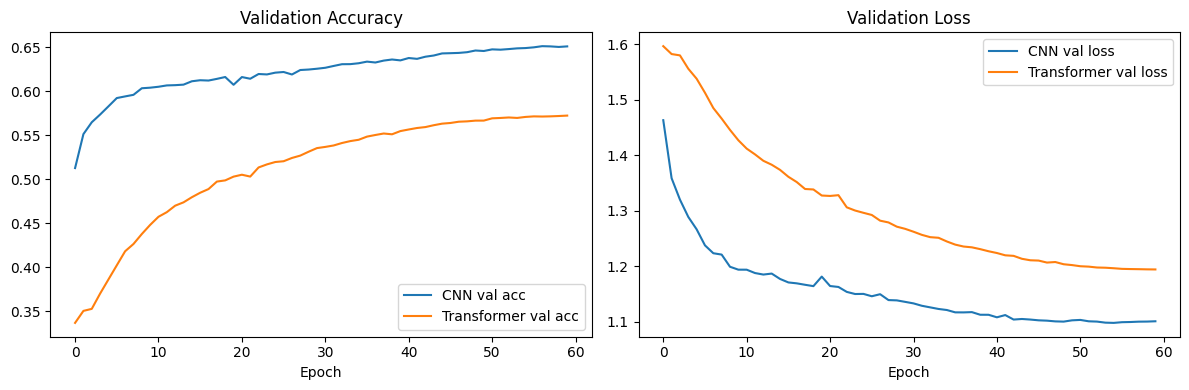

Comparison plot saved.


In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(cnn_history.history['val_accuracy'], label='CNN val acc')
axes[0].plot(trans_history.history['val_accuracy'], label='Transformer val acc')
axes[0].set_title('Validation Accuracy')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(cnn_history.history['val_loss'], label='CNN val loss')
axes[1].plot(trans_history.history['val_loss'], label='Transformer val loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].set_xlabel('Epoch')
plt.tight_layout()
plt.savefig(f'{MODEL_DIR}/cnn_vs_transformer.png', dpi=150)
plt.show()
print('Comparison plot saved.')